# Mars Landing Site Identification
MAT 494, Spring 2023

### Base setup

In [1]:
# base libraries
import numpy as np
from matplotlib import pyplot as plt
import math
import random

# note: cv2 is deprecated, and opencv doesn't appear to install on the conda forge registry?
import cv2

In [2]:
import imageio
from skimage.segmentation import chan_vese

In [46]:

import rasterio
import cartopy.crs as ccrs
from rasterio import features
import shapely
from trimesh.path.polygons import sample

### Data loading

In [4]:
# file paths
# OFFICIAL resolution: (2880, 5760)
elev_file ="test_data/megt90n000fb.img"
dust_file = "test_data/dci_lo_ice_dust_16ppd_shifted.raw"
TI_file = "test_data/ti16"
alb_file = "test_data/alb32"
tes_file = "test_data/TES_Glass_Clay_numeric"

In [5]:
def load_elevation(file):
    with open(file,"rb") as f:
        dat = f.read()
        z=np.frombuffer(dat, dtype='>i2').reshape(720*8,1440*8).astype(np.float64)
        
    return z

In [6]:
def load_dci(file):
    with open(file,"rb") as f:
        dat = f.read()
    dci = np.frombuffer(dat,dtype=np.float32).reshape(2880,5760)
    return dci

In [7]:
def load_TI(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    ti = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.int32).reshape(1440,2880)
    return ti

In [8]:
def load_alb(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    alb = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.float32).reshape(1440,2880)
    return alb

In [9]:
def load_TES(file, VICAR_LBLSIZE=5760):
    with open(file,"rb") as f:
        dat = f.read()
    TES = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.float32).reshape(720,1440)
    return TES

In [10]:
def roll_dci(dci, ROLL=2880):
    return np.roll(dci, ROLL, axis=1)

In [11]:
def downsample_elevation(elev):
    return elev[0::2,0::2]

In [12]:
def scale_up(arr):
    h,w = arr.shape[:2]
    # Nearest Neighbor interpolation
    new_arr = np.zeros((h*2, w*2))
    
    new_arr[0::2,0::2] = arr
    new_arr[1::2,0::2] = arr
    new_arr[0::2,1::2] = arr
    new_arr[1::2,1::2] = arr
    
    return new_arr

In [13]:
# Load Files
elev = load_elevation(elev_file)
dci = load_dci(dust_file)
ti = load_TI(TI_file)
alb = load_alb(alb_file)
TES = load_TES(tes_file)

# Pre Process
elev = downsample_elevation(elev)
dci = roll_dci(dci)
ti = scale_up(ti)
alb = scale_up(alb)
TES = scale_up(scale_up(TES))

assert elev.shape == dci.shape == ti.shape == alb.shape == TES.shape

In [14]:
elev[0::2,0::2].shape

(1440, 2880)

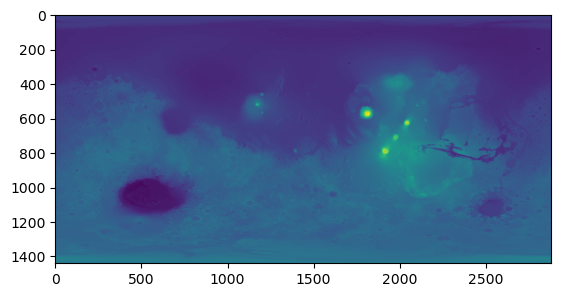

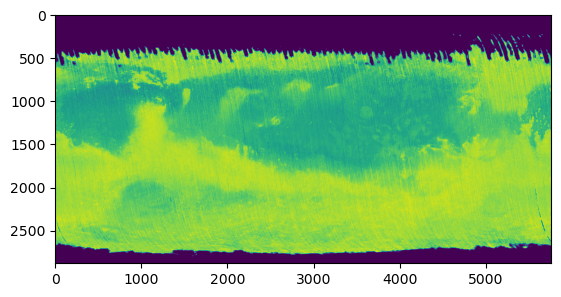

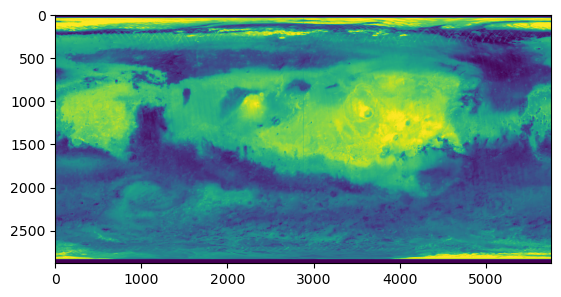

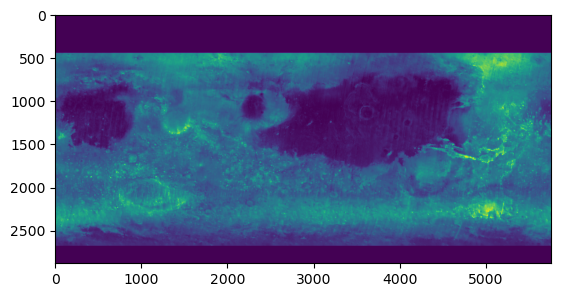

In [15]:
plt.imshow(elev[0::2,0::2])
plt.show()
plt.imshow(dci)
plt.show()
plt.imshow(alb)
plt.show()
plt.imshow(ti)
plt.show()

In [16]:
elev<0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

np.frombuffer(dat).reshape(5760,2880)

In [17]:
33177600/5760

5760.0

### Constraint identification

In [18]:
# setting up conditions
# elevation (km)
min_elev = -(math.inf)
max_elev = -1.3

# thermal inertia (TI)
min_ti = 200
max_ti = 250
# min_ti = 1
# max_ti = math.inf

# albedo
min_alb = 0.18
max_alb = 0.26

# dust cover index (DCI)
min_dci = 0.93
max_dci = 0.97

### Filters

#### Boolean filters

In [19]:
# boolean filtering
elev_mask = [(elev > min_elev) & (elev <= max_elev)][0]
ti_mask = [(ti > min_ti) & (ti <= max_ti)][0]
alb_mask = [(alb > min_alb) & (alb <= max_alb)][0]
dci_mask = [(dci > min_dci) & (dci <= max_dci)][0]

# alternative mask for ti and alb
alt_mask = ti > (300 * alb + 180)

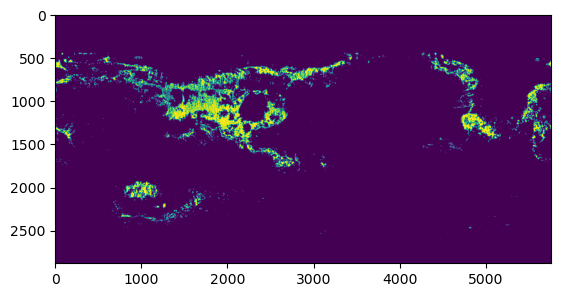

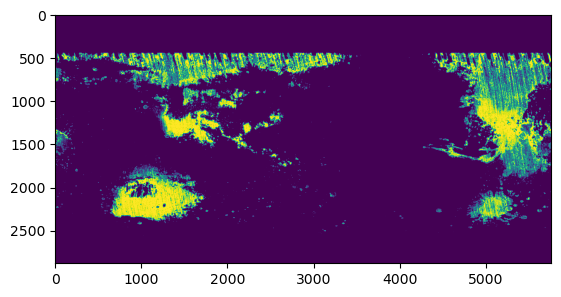

In [20]:
plt.imshow(elev_mask & ti_mask & alb_mask & dci_mask)
plt.show()
plt.imshow(elev_mask & alt_mask & dci_mask)
plt.show()

#### Spatial filters

In [21]:
# convert given latitude to absolute measure
def absolute_latitude(latitude):
    # positive: find distance from top
    if latitude > 0:
        return 90 - latitude
    # negative: find cumulative distance from top
    else:
        return abs(latitude) + 90

In [22]:
# find image's vertical interval equivalent to a latitudinal slice
def latitude_intervals(bottom, top, dim_y):
    # per-degree equivalence factor
    factor = dim_y / 180

    # convert latitudes
    new_bottom = absolute_latitude(bottom) * factor
    new_top = absolute_latitude(top) * factor

    # remove rounding errors
    return (round(new_bottom), round(new_top))

In [23]:
# generate the boolean latitude mask
def latitude_mask(bottom, top, dim_x, dim_y):
    # empty boolean mask
    base_mask = np.full((dim_x, dim_y), False)

    # get correct latitudes
    (new_bottom, new_top) = latitude_intervals(bottom, top, dim_x)

    # iterate over latitude interval to make mask
    for x in range(new_top, new_bottom, 1):
        for y in range(len(base_mask[0])):
            base_mask[x][y] = True
    
    # done
    return base_mask

In [24]:
# convert given longitude to absolute measure
def absolute_longitude(longitude):
    # positive: find distance from top
    if longitude > 0:
        return 180 + longitude
    # negative: find cumulative distance from top
    else:
        return 180 - abs(longitude)

In [25]:
# find image's vertical interval equivalent to a latitudinal slice
def longitude_intervals(left, right, dim_y):
    # per-degree equivalence factor
    factor = dim_y / 360

    # convert latitudes
    new_left = absolute_longitude(left) * factor
    new_right = absolute_longitude(right) * factor
    
    # remove rounding errors
    return (round(new_left), round(new_right))

In [26]:
# generate the boolean latitude mask
def longitude_mask(left, right, dim_x, dim_y):
    # empty boolean mask
    base_mask = np.full((dim_x, dim_y), False)

    # get correct latitudes
    (new_left, new_right) = longitude_intervals(left, right, dim_y)

    # iterate over latitude interval to make mask
    for x in range(len(base_mask)):
        for y in range(new_left, new_right + 1, 1):
            base_mask[x][y] = True
    
    # done
    return base_mask

In [27]:
# example mask: -30deg South, 60deg North
lat_mask = latitude_mask(-30, 60, 2880, 5760)

# example mask: -90deg West, 90deg East
lon_mask = longitude_mask(-90, 90, 2880, 5760)

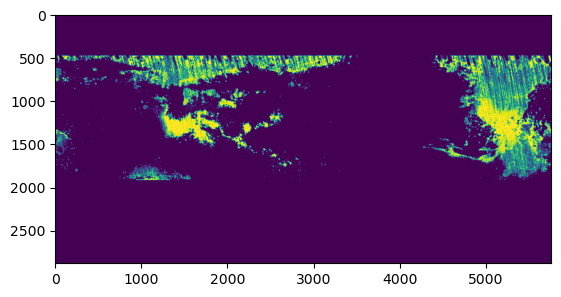

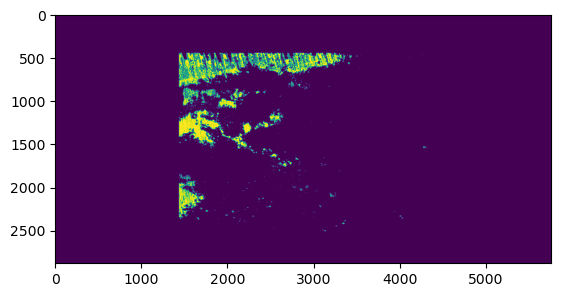

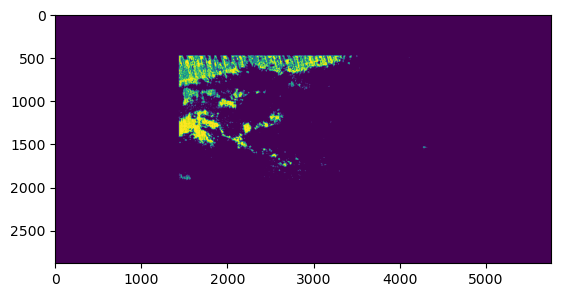

In [28]:
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lat_mask)
plt.show()
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lon_mask)
plt.show()
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lat_mask & lon_mask)
plt.show()

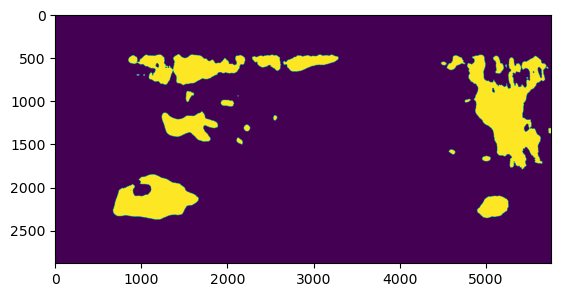

In [29]:
import cv2
rad=101
im = elev_mask & alt_mask & dci_mask
im = np.uint8(255*im)
#cv2.imshow("",im)
#cv2.waitKey()
im = cv2.medianBlur(im, rad)

plt.imshow(im)
plt.show()

im = cv2.medianBlur(im, rad)

In [30]:
from scipy.signal import fftconvolve

masked_TES = TES*(elev_mask & alt_mask & dci_mask & (TES>-1))

# essentially a low pass filter
kernel = np.ones((101, 101), np.float32)

heatmap = fftconvolve(masked_TES, kernel, mode="same")

### Level Set Region Segmentation

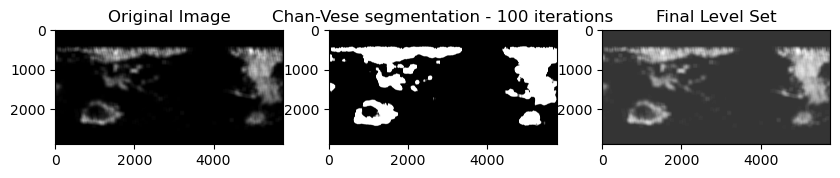

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# source img is prior heatmap
sampled_img = heatmap
gray_heatmap = sampled_img

# Computing the Chan VESE segmentation technique
chanvese_output = chan_vese(gray_heatmap, max_num_iter=100, extended_output=True)

ax = axes.flatten()

# original image
ax[0].imshow(gray_heatmap, cmap="gray")
ax[0].set_title("Original Image")

# segmented image
ax[1].imshow(chanvese_output[0], cmap="gray")
title = "Chan-Vese segmentation - 100 iterations"
format(len(chanvese_output[2]))

ax[1].set_title(title)

# level set
ax[2].imshow(chanvese_output[1], cmap="gray")
ax[2].set_title("Final Level Set")
plt.show()


In [32]:
mask = chanvese_output[0]

all_polygons = []
for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
    all_polygons.append(shapely.geometry.shape(shape))

all_polygons = shapely.geometry.MultiPolygon(all_polygons)
if not all_polygons.is_valid:
    all_polygons = all_polygons.buffer(0)
    if all_polygons.type == 'Polygon':
        all_polygons = shapely.geometry.MultiPolygon([all_polygons])

polygons = all_polygons

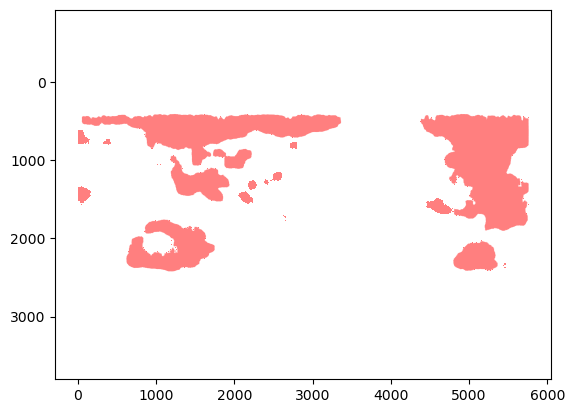

In [33]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for geom in polygons.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

axs.invert_yaxis()

plt.show()

In [34]:
# # TODO: sample level set (from multipolygonal geometry)
# import random
# from shapely.affinity import affine_transform
# from shapely.geometry import Point, Polygon
# from shapely.ops import triangulate

# base_polygon = polygons
# k = 10

# areas = []
# transforms = []
# points = []

# for t in triangulate(base_polygon):
#     areas.append(t.area)
#     (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
#     transforms.append([x1 - x0, x2 - x0, y2 - y0, y1 - y0, x0, y0])

# for transform in random.choices(transforms, weights=areas, k=k):
#     x, y = [random.random() for _ in range(2)]
#     if x + y > 1:
#         p = Point(1 - x, 1 - y)
#     else:
#         p = Point(x, y)
#     points.append(affine_transform(p, transform))

In [47]:
points = sample(polygons, 10)

In [35]:
# convert coordinate to a [-dim/2, +dim/2] scaled domain
def relative_coordinate(position, dim):
    dim_origin = dim/2
    if position > dim_origin:
        return position - dim_origin
    else:
        return -dim_origin + position

In [36]:
# convert y points
def convert_coordinates(source_points, source_dim, destination_dim):
    conversion_factor = destination_dim / source_dim
    new_points = [relative_coordinate(point * conversion_factor, destination_dim) for point in source_points]
    return new_points

In [61]:
points_geoms = points
old_x = [geom[0] for geom in points_geoms]
old_y = [geom[1] for geom in points_geoms]

# TODO: check if conversion is correct
sample_x = convert_coordinates(old_x, 5760, 360)
sample_y = [-1 * val for val in convert_coordinates(old_y, 2880, 180)]

In [62]:
display(old_x)
display(old_y)

display(sample_x)
display(sample_y)

[4895.552378938701,
 1470.9844429498826,
 5397.608085155803,
 904.7755245127491,
 5552.906323873468,
 5247.33088507759,
 5425.994510973699,
 743.8988823509166,
 4952.928838624796,
 4818.689543126133]

[1216.6286902684083,
 2124.3676486596714,
 1832.8147794682409,
 2305.8374151357184,
 1333.9827713114894,
 582.5808945835174,
 1806.6527926989368,
 2195.8705118527714,
 2286.420694429931,
 1096.510044885759]

[125.9720236836688,
 -88.06347231563234,
 157.35050532223767,
 -123.45152971795318,
 167.05664524209175,
 147.9581803173494,
 159.1246569358562,
 -133.5063198530677,
 129.55805241404977,
 121.1680964453833]

[13.960706858224484,
 -42.772978041229464,
 -24.550923716765055,
 -54.1148384459824,
 6.626076793031913,
 53.58869408853016,
 -22.915799543683548,
 -47.24190699079821,
 -52.901293401870674,
 21.46812219464006]

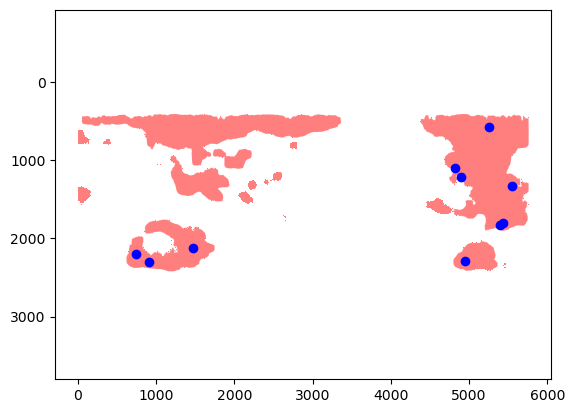

In [58]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for geom in polygons.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

axs.scatter(old_x,old_y,color='blue')
axs.invert_yaxis()

plt.show()

### Display: Rotating Mars

In [63]:
# generate longitudinal views for rotation (must be an evenly-divisible integer with 360 as dividend)
no_views = 24
all_views = [[x,0] for x in range(-180,180 + 1,no_views)]

# TEST: generate a set of 100 points to check if plotting works as expected
test_x = random.sample(range(-180, 180 + 1), 10)
test_y = random.sample(range(-90, 90 + 1), 10)

# source of basemap
img = plt.imread('./test_data/Mars_Viking_ClrMosaic_global_925m_downscaled.jpg')

# plot for each possible views
for idx, current_view in enumerate(all_views):
    # view config
    save_name = f"./figures/mars_view_{idx}"
    title_name = f"Lat.: {current_view[0]}, Lon: {current_view[1]}"

    # set source, dest coordinate reference system (type of map)
    data_crs = ccrs.PlateCarree()
    projection = ccrs.Orthographic(*current_view)

    # init plot
    fig = plt.figure(figsize = (6,6))
    ax  = plt.axes(projection = projection)

    # plot the map + points
    # TODO: add latitudes of constraint
    ax.imshow(img, extent = [-180, 180, -90, 90], transform = data_crs, interpolation='spline36')
    ax.scatter(test_x,test_y,transform=ccrs.Geodetic(),color='red')
    ax.scatter(sample_x,sample_y,transform=ccrs.Geodetic(),color='blue')
    ax.set_axis_off()

    # save plot
    plt.title(title_name, fontweight='bold')
    plt.savefig(save_name)
    plt.close()

In [64]:
# interpolate all views into gif
frames = []
no_views = 24
time = int(360/no_views) + 1;

# stitch all frames together
for t in range(time):
    image = imageio.v2.imread(f'./figures/mars_view_{t}.png')
    frames.append(image)

# save resultant gif
imageio.mimsave('./rotating_mars.gif', frames, fps = 1.5)

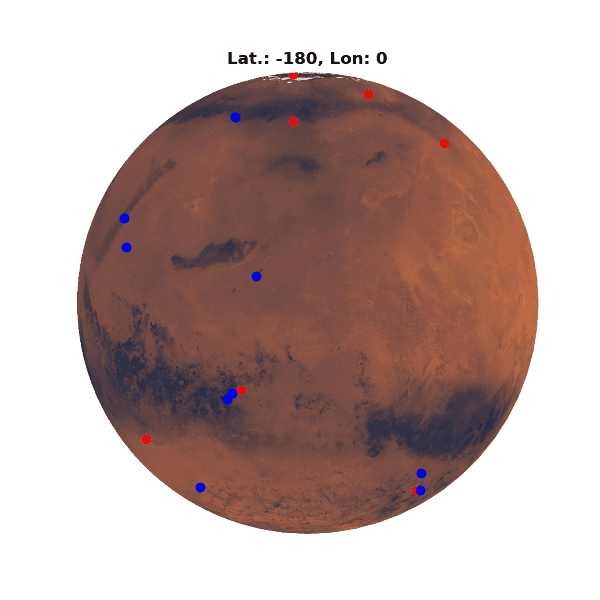

In [65]:
from IPython.display import Image

Image(open('./rotating_mars.gif','rb').read())